In [1]:
import random
import pandas as pd
import os

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image, ImageFilter

import keras.backend as KerasBackend

from skimage.transform import resize

import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
import keras
import cv2

import tensorflow as tf
import keras.utils as np_utils


import tqdm

from keras.preprocessing import image
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm_NB


import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


from keras.preprocessing.image import ImageDataGenerator

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

c:\users\buckf\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
df_depths = pd.read_csv('data/depths.csv', index_col='id')
df_depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


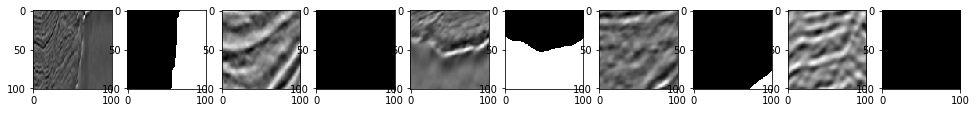

In [4]:
ids= ['4ac19fb269','1825fadf99','f59821d067','5b435fad9d','e340e7bfca']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = image.load_img('data/train/images/' + img_name + '.png')
    img_mask = image.load_img('data/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
path_train = 'data/train/'
path_test = 'data/test/'

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [6]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


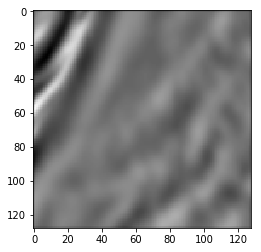

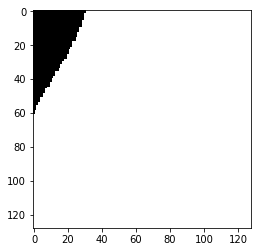

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [8]:
X_train.shape

(4000, 128, 128, 1)

In [9]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = merge([u6,c4], mode = 'concat', concat_axis = 3)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = merge([u7,c3], mode = 'concat', concat_axis = 3)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = merge([u8,c2], mode = 'concat', concat_axis = 3)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = merge([u9,c1], mode = 'concat', concat_axis = 3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=2, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=32, epochs=15, verbose= 2, 
                    callbacks=[earlystopper, checkpointer])

Train on 2800 samples, validate on 1200 samples
Epoch 1/15
 - 27s - loss: 0.5813 - mean_iou: 0.3666 - val_loss: 0.5486 - val_mean_iou: 0.3734

Epoch 00001: val_loss improved from inf to 0.54857, saving model to model-tgs-salt-1.h5
Epoch 2/15
 - 19s - loss: 0.5167 - mean_iou: 0.3743 - val_loss: 0.4821 - val_mean_iou: 0.3738

Epoch 00002: val_loss improved from 0.54857 to 0.48208, saving model to model-tgs-salt-1.h5
Epoch 3/15
 - 19s - loss: 0.4225 - mean_iou: 0.3866 - val_loss: 0.3990 - val_mean_iou: 0.4057

Epoch 00003: val_loss improved from 0.48208 to 0.39905, saving model to model-tgs-salt-1.h5
Epoch 4/15
 - 19s - loss: 0.3653 - mean_iou: 0.4229 - val_loss: 0.3477 - val_mean_iou: 0.4453

Epoch 00004: val_loss improved from 0.39905 to 0.34772, saving model to model-tgs-salt-1.h5
Epoch 5/15
 - 19s - loss: 0.3385 - mean_iou: 0.4640 - val_loss: 0.3442 - val_mean_iou: 0.4754

Epoch 00005: val_loss improved from 0.34772 to 0.34420, saving model to model-tgs-salt-1.h5
Epoch 6/15
 - 19s - l

In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [12]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=0)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=0)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 32 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA

In [13]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tqdm.tnrange(len(preds_test)):
    # We need to resize the images from 128 x 128 back to 101 x 101 pixels. 
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [14]:
preds_test_upsampled[0].shape

(101, 101)

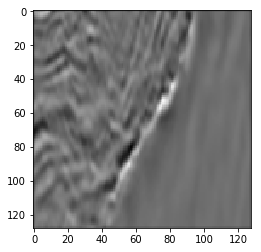

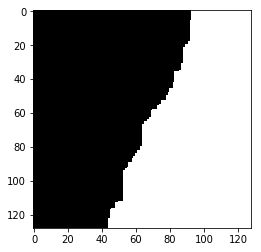

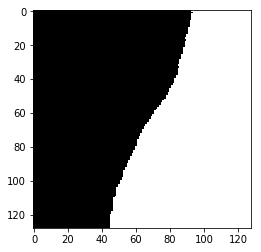

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()


y_img = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((y_img,y_img,y_img)))
plt.show()


pred_img = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((pred_img,pred_img,pred_img)))
plt.show()

In [16]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_NB(enumerate(test_ids))}

In [17]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [31]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [52]:
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-2-AUG.h5', verbose=  2, save_best_only=True)
results_aug = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32, epochs = 15, verbose = 2,
                    callbacks=[earlystopper, checkpointer]))

TypeError: flow() got an unexpected keyword argument 'epochs'

In [ ]:
#To Save Augmented Images to a file.

earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-2-AUG.h5', verbose= 2, save_best_only=True)

epochs = 10
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32, save_to_dir=r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\AUG_IMAGES", save_prefix='AUG_IMAGE'),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs, verbose = 2, callbacks=[earlystopper, checkpointer])

In [54]:
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-2-AUG.h5', verbose= 2, save_best_only=True)

epochs = 10
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs, verbose = 2, callbacks=[earlystopper, checkpointer])

Epoch 1/10
 - 16s - loss: 0.3455 - mean_iou: 0.5540
Epoch 2/10
 - 15s - loss: 0.3544 - mean_iou: 0.5544
Epoch 3/10
 - 16s - loss: 0.3484 - mean_iou: 0.5546
Epoch 4/10
 - 16s - loss: 0.3450 - mean_iou: 0.5549
Epoch 5/10
 - 16s - loss: 0.3489 - mean_iou: 0.5555
Epoch 6/10
 - 16s - loss: 0.3526 - mean_iou: 0.5557
Epoch 7/10
 - 16s - loss: 0.3546 - mean_iou: 0.5558
Epoch 8/10
 - 16s - loss: 0.3439 - mean_iou: 0.5561
Epoch 9/10
 - 16s - loss: 0.3517 - mean_iou: 0.5563
Epoch 10/10
 - 16s - loss: 0.3433 - mean_iou: 0.5565
